<a href="https://colab.research.google.com/github/YuLiu83/Practical-business-case-code-demo/blob/main/Mallet_implementation_of_Topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective:

Business often possesses large amount of text documents such as customer reviews, technician logs or legal documents. To find potential business opprtunities, data scientists utilize topic modeling techniques which often provide quick ways of gaining insights from large amount of text documents. LDA model is one of most popular unsupervised learning approches that help achieving this goal when there are no pre-known topics. Popular data scinece packages such as Gensim, Mallet and Scikit-learn provide such implementation. The exercise in this notebook demonstrates this powerful analysis by utilizing Mallet LDA implementations to extract topics from '20 news group' data.

In [ ]:
# Load google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
def install_java_jdk():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java_jdk()

openjdk version "11.0.7" 2020-04-14
OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04)
OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)


In [ ]:
# Install additioanal Packages
!pip install pyLDAvis
!pip install --upgrade gensim
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip 
!unzip mallet-2.0.8.zip

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)
--2020-05-25 18:31:25--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  10.1MB/s    in 1.5s    

2020-05-25 18:31:27 (10.1 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
from glob import glob
import re, string
import pandas as pd
import numpy as np

import gensim
from gensim.utils import simple_preprocess
from gensim import models
from gensim import corpora
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.phrases import Phrases, Phraser

from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME']='/content/mallet-2.0.8'
mallet_path = r'/content/mallet-2.0.8/bin/mallet'


import spacy
!python -m spacy download en_core_web_lg

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from gensim.models import CoherenceModel

import pyLDAvis.gensim as gensimvis
import pyLDAvis

import matplotlib.pyplot as plt

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

# Examine data
print('20 Unique Topics:  ', df.target_names.unique())
print('Number of Documents:  ', len(df.content), 'documents')
df.head()


20 Unique Topics:   ['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']
Number of Documents:   11314 documents


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


Though the study is focused on unsupervised learning (assume no pre-known document labels), let's cheat a little by peeking into the given groups so we roughly know how many groups to expect from the optimized model.

In [ ]:
known_topic_dist=df.target_names.value_counts().reset_index()
known_topic_dist.columns = ['Category', 'Document Num']
known_topic_dist

,Category,Document Num
0,rec.sport.hockey,600
1,soc.religion.christian,599
2,rec.motorcycles,598
3,rec.sport.baseball,597
4,sci.crypt,595
5,sci.med,594
6,rec.autos,594
7,comp.windows.x,593
8,sci.space,593
9,sci.electronics,591


In [ ]:
# Initial text data preparation:
# Convert to list
docs_raw = df.content.values.tolist()

def data_preparation(docs_list):
# Remove Emails
  docs_list  = [re.sub(r'\S*@\S*\s?', '', sent) for sent in docs_list ]
# Remove new line characters
  docs_list  = [re.sub(r'\s+', ' ', sent) for sent in docs_list]
# Remove distracting single quotes
  docs_list  = [re.sub(r"\'", "", sent) for sent in docs_list ]
# Tokenize
  docs_list  = [simple_preprocess(sent, min_len=3) for sent in docs_list ]
  return docs_list

docs_list=data_preparation(docs_raw)



In [ ]:
# Train the bigram and trigram models
bigram = Phrases(docs_list, min_count=10, threshold=4) # higher threshold fewer phrases.
trigram = Phrases(bigram[docs_list], min_count=10, threshold=4)  

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Prepare stop word list (NLTK)
# It depends on nature of document to decide stop word list. E.g. If doucment contains term 'New York', new should not be treated as a stop word.
stop_words = stopwords.words('english')
stop_words.extend(["max", "thanks","just", "right", "like", 'from', 'subject', 're', 'use'])
# other stop words may consider to remove ['thing']

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# Stop words were still included in the trained n-gram model, but will not be reflected in the processed docs since stop words are removed first.
# It may be not recommended to remove the stop words before n-gran training. 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#    """https://spacy.io/api/annotation"""
    
#    texts_out = []
#    for sent in texts:
#        doc = nlp(" ".join(sent)) 
#        texts_out.append([token.lemma_ for token in doc]) # if only keep the tokens with given posttags, add 'if token.pos_ in allowed_postags'
#    return texts_out

# Visually compared NLTK and Gensim based lemmetization results, prefered NLTK results. 


In [ ]:
# NLTK Lemmetizer
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
# Call functions

# Remove Stop Words
data_words_nostops = remove_stopwords(docs_list)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Lemmatization
Data_Lemmatized=[]
holder=[]
for i in data_words_trigrams:
  holder=[]
  for j in i:
    holder.append(WordNetLemmatizer().lemmatize(j, get_wordnet_pos(j)))
  Data_Lemmatized.append(holder)
  



In [ ]:
# Create Dictionary and Corpus

dictionary=Dictionary(data_lemmatized)
dictionary.filter_extremes(no_below=10, no_above=0.4, keep_n=None)
dictionary.compactify() # re-assign id

corpus = [dictionary.doc2bow(i) for i in data_lemmatized]

In [ ]:
# Save the Dictionary and Corpus
dictionary.save('/content/drive/My Drive/newsgroup_dictionary.dict')  # save dict to disk
MmCorpus.serialize('/content/drive/My Drive/newsgroup_corpus.mm', corpus)  # save corpus to disk

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# Load the saved Dictiaonry and Corpus
dictionary_reload = corpora.Dictionary.load('/content/drive/My Drive/newsgroup_dictionary.dict')
corpus_reload = corpora.MmCorpus('/content/drive/My Drive/newsgroup_corpus.mm')

In [ ]:
# Find the optimal number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=4, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, iterations=1000, random_seed=0) # newer version allows random_seed=state
        #model =models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v') #{'u_mass', 'c_v', 'c_uci', 'c_npmi'}
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_reload, corpus=corpus_reload, texts=Data_Lemmatized, start=10, limit=25, step=1)

CPU times: user 6min 25s, sys: 1.31 s, total: 6min 27s
Wall time: 27min 16s


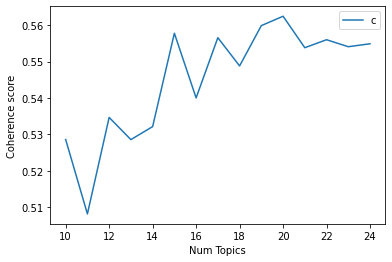

In [ ]:
# Show graph
start=10; limit=25; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
# model_list[4] the optimal model

Num Topics = 10  has Coherence Value of 0.5286
Num Topics = 11  has Coherence Value of 0.5082
Num Topics = 12  has Coherence Value of 0.5347
Num Topics = 13  has Coherence Value of 0.5286
Num Topics = 14  has Coherence Value of 0.5322
Num Topics = 15  has Coherence Value of 0.5578
Num Topics = 16  has Coherence Value of 0.54
Num Topics = 17  has Coherence Value of 0.5566
Num Topics = 18  has Coherence Value of 0.5488
Num Topics = 19  has Coherence Value of 0.5599
Num Topics = 20  has Coherence Value of 0.5624
Num Topics = 21  has Coherence Value of 0.5538
Num Topics = 22  has Coherence Value of 0.556
Num Topics = 23  has Coherence Value of 0.5541
Num Topics = 24  has Coherence Value of 0.5549


In [ ]:
# Convert mallet model to gensim.lda model
#Defining helper function below as default gensim wrapper having bugs causing pyLDAvis unable to plot proper topics: 'model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)'

def mallet_to_lda(mallet_model):
    model_gensim = models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [ ]:
# Save the selected optimal topic model
Mallet=mallet_to_lda(model_list[10])
Mallet.save('/content/drive/My Drive/Mallet.model')

In [ ]:
# Loading the saved model 
Mallet = models.ldamodel.LdaModel.load('/content/drive/My Drive/Mallet.model')
# if issues with loaded model, make sure gensim is the latest version

In [ ]:
vis_data = gensimvis.prepare(Mallet, corpus_reload, dictionary_reload, mds='mmds', sort_topics=False) #mds='mmds'/'tsne'/'pcoa' for dimension reduction # 3 components- fitted model, corpus(term_id, count), dictionary
pyLDAvis.display(vis_data)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


Cohenrence scores recommend 20 topics as optimal number of topics, which is the same as the known number of topics pre-known from original documents.

### Summarize 20 topics by learnings from the pyLDAvis graph:

Topic 1: Gun laws

Topic 2: Sports/Sport teams (Hockey, Basketball)

Topic 3: Electric circuit

Topic 4: Q/A*

Topic 5:  Religion, Atheist, Belief

Topic 6: Cyber security/privacy

Topic 7: Gun related crimes

Topic 8: Surviving family

Topic 9: War/War crime

Topic 10: Health/Medicine

Topic 11: Computer parts and office machines

Topic 12: Vehicles

Topic 13: Space science

Topic 14: Process improvement*

Topic 15: Economy, Investment

Topic 16: Academic publication

Topic 17: Computer graphics

Topic 18: Computer commands

Topic 19: Sales

Topic 20: Religion, Church

Comparing to the 20 known topics below, the 20 naturally learned topics have a lot in common. **The size of each circle** represents relative document size within, the **relative distance** between topics represents how closely they are related to each other. * Blur topics


## Finding the dominant topic in each sentence:

Code below finds the dominant topic for each document by finding the topic having the highest % contribution in that document. (Setting all topic contribution in one document adding up to one.)

In [ ]:
def format_topics_sentences(ldamodel=Mallet, corpus=corpus_reload, texts=docs_raw):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=Mallet, corpus=corpus_reload, texts=docs_raw)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.0516,"post, question, article, point, read, find, an...",From: lerxst@wam.umd.edu (where's my thing)\nS...
1,1,8.0,0.0524,"attack, kill, war, land, give, today, people, ...",From: guykuo@carson.u.washington.edu (Guy Kuo)...
2,2,2.0,0.0542,"drive, power, ground, work, switch, wire, cabl...",From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3,3,10.0,0.0521,"problem, card, system, run, driver, machine, d...",From: jgreen@amber (Joe Green)\nSubject: Re: W...
4,4,17.0,0.0523,"file, line, change, program, follow, set, bit,...",From: jcm@head-cfa.harvard.edu (Jonathan McDow...
5,5,3.0,0.0535,"post, question, article, point, read, find, an...",From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...
6,6,10.0,0.0519,"problem, card, system, run, driver, machine, d...",From: bmdelane@quads.uchicago.edu (brian manni...
7,7,9.0,0.0532,"study, drug, food, problem, effect, doctor, pe...",From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...
8,8,16.0,0.0515,"window, image, program, application, display, ...",From: holmes7000@iscsvax.uni.edu\nSubject: WIn...
9,9,13.0,0.0540,"time, make, thing, call, lot, put, hear, work,...",From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...


## Present most representative documents for each topic:
This summary table helps finding most representative documents from raw data that represent each of the learned topics.


In [ ]:
Num_doc=1 # Top n document for each topic

sent_topics = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics= pd.concat([sent_topics, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(Num_doc)],axis=0)

# Reset Index    
sent_topics.reset_index(drop=True, inplace=True)

# Format
sent_topics.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics.head(20)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1109,"people, government, state, power, support, cou...",From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...
1,1.0,0.1225,"game, team, play, player, win, year, season, h...",From: dlecoint@garnet.acns.fsu.edu (Darius_Lec...
2,2.0,0.1042,"drive, power, ground, work, switch, wire, cabl...",From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...
3,3.0,0.2957,"post, question, article, point, read, find, an...",From: art@cs.UAlberta.CA (Art Mulder)\nSubject...
4,4.0,0.0605,"claim, exist, argument, reason, evidence, trut...",From: dnadams@nyx.cs.du.edu (Dean Adams)\nSubj...
5,5.0,0.1080,"system, chip, key, message, information, inter...",From: tgl+@cs.cmu.edu (Tom Lane)\nSubject: JPE...
6,6.0,0.1937,"gun, law, case, crime, weapon, carry, state, f...",From: dbd@urartu.sdpa.org (David Davidian)\nSu...
7,7.0,0.3202,"people, child, start, leave, woman, happen, fi...",From: hamlet@stein.u.washington.edu (Mitch McG...
8,8.0,0.0965,"attack, kill, war, land, give, today, people, ...",From: david@stat.com (David Dodell)\nSubject: ...
9,9.0,0.0672,"study, drug, food, problem, effect, doctor, pe...",From: jlevine@rd.hydro.on.ca (Jody Levine)\nSu...


## Document distribution across Topics

Summary below numerically shows Autovehicle is the smallest topic with 695 related documents and Religion is the largest topic with 1,645 related documents. The relative size of the documents can also be observed in pyLDAvis graph.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"people, government, state, power, support, cou...",533,0.0471
1.0,1.0,"game, team, play, player, win, year, season, h...",521,0.0460
2.0,2.0,"drive, power, ground, work, switch, wire, cabl...",537,0.0475
3.0,3.0,"post, question, article, point, read, find, an...",1245,0.1100
4.0,4.0,"claim, exist, argument, reason, evidence, trut...",182,0.0161
5.0,5.0,"system, chip, key, message, information, inter...",433,0.0383
6.0,6.0,"gun, law, case, crime, weapon, carry, state, f...",529,0.0468
7.0,7.0,"people, child, start, leave, woman, happen, fi...",862,0.0762
8.0,8.0,"attack, kill, war, land, give, today, people, ...",490,0.0433
9.0,9.0,"study, drug, food, problem, effect, doctor, pe...",312,0.0276


## Conclusion:
Mallet implementation provides the best topic modeling (the closest number of topics to known and the highest cohenerence score) comparing to gensim and sk-learn approches. Resulted groups captured meaningful and detailed subjects which are close to known topics from given documents.

As a next step, there are still improvement opportunities to help model create more distinguishable groups and select key words that better describe the subject. Enhencing technique may include but not limited to more detailed text pre-processing, increase model training iteration, use tf-idf vectorizer instead of simple term frequency vectorizer.